In [2]:
%matplotlib inline
import re
import string
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)
from tensorflow.keras.preprocessing import image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, Bidirectional
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout, LSTM
from tensorflow.keras.layers import Conv1D, Embedding, GlobalAveragePooling1D , MaxPooling2D

In [3]:
df = pd.read_csv('memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df.drop(columns = ['text_ocr', 'humour', 'sarcasm', 'offensive', 'motivational'])
df.head()

,image_name,text_corrected,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,positive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral


In [4]:
cleaned = df.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

image_name           False
text_corrected       False
overall_sentiment    False
dtype: bool

In [5]:
width = 60
height = 60
X = []
for i in tqdm(range(cleaned.shape[0])):
    if i in [119, 4799, 6781, 6784, 6786]:
        pass
    else:
        path = 'memotion_dataset_7k/images/'+cleaned['image_name'][i]
        img = image.load_img(path,target_size=(width,height,3))
        img = image.img_to_array(img)
        img = img/255.0
        X.append(img)
        
X = np.array(X)

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 6676/6987 [01:36<00:03, 91.12it/s]D:\Users\hp\anaconda3\envs\tf\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6987/6987 [01:39<00:00, 70.37it/s]


In [6]:
X.shape

(6982, 60, 60, 3)

In [7]:
rows_to_drop = ['image_120.jpg',
              'image_4800.jpg',
              'image_6782.jpg',
              'image_6785.jpg',
              'image_6787.jpg',
              'image_6988.jpg',
              'image_6989.jpg',
              'image_6990.png',
              'image_6991.jpg',
              'image_6992.jpg']

In [8]:
for images in rows_to_drop:
    cleaned.drop(cleaned[cleaned['image_name'] == images].index, inplace=True)

In [9]:
import nlpaug
import nlpaug.augmenter.word as naw
from imgaug import augmenters as iaa
def Augmentation(text, images, labels):
    aug = naw.SynonymAug(aug_src='wordnet',aug_max=3)
    augmented_sentences = []
    augmented_sentences_labels = []
    augmented_images = []
    for i in range(0, len(text)):
        if np.argmax(labels.iloc[i]) == 0:
            t = 'negative'
            temps = aug.augment(text.iloc[i],n=6)
            for j in range(6):
                trans = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=(10,30))])
                augmented_images.append(trans(image = images[i]))
                image = augmented_images[j]
        elif np.argmax(labels.iloc[i]) == 1:
            t = 'neutral'
            temps = aug.augment(text.iloc[i],n=2)
            for j in range(2):
                trans = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=(10,30))])
                augmented_images.append(trans(image = images[i]))
                image = augmented_images[j]
        else:
            augmented_sentences.append(text.iloc[i])
            augmented_sentences_labels.append('positive')
            augmented_images.append(images[i])
            continue
        for sent in temps:
            augmented_sentences.append(sent)
            augmented_sentences_labels.append(t)
        
    return augmented_sentences, augmented_images, augmented_sentences_labels

In [10]:
target = cleaned['overall_sentiment']
target = pd.get_dummies(target)
text, images, sent = Augmentation(cleaned.text_corrected, X, target)
cleaned = pd.DataFrame()
cleaned['text'] = text
cleaned['sentiment'] = sent

In [11]:
target = cleaned['sentiment']
target = pd.get_dummies(target)
cleaned.shape, np.array(images).shape,target.shape

((12335, 2), (12335, 60, 60, 3), (12335, 3))

In [12]:
cleaned['sentiment'].value_counts()

neutral     4396
positive    4153
negative    3786
Name: sentiment, dtype: int64

In [13]:
X.shape

(6982, 60, 60, 3)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(images, target, test_size = 0.2, stratify=target)

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomContrast([.5,2]),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [16]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(cleaned.text, target, test_size = 0.2, stratify=target)

In [17]:
base_model_1 = tf.keras.applications.ResNet50(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')
# base_model_2 = tf.keras.applications.VGG16(input_shape=X[0].shape,
#                                                include_top=False,
#                                                weights='imagenet')

In [18]:
base_model_1.trainable = False
#base_model_2.trainable = False

In [19]:
def image_model():
    image_input = tf.keras.Input(shape=(60, 60, 3), name = 'image_input')
    image_layers = data_augmentation(image_input)
    image_layers = preprocess_input(image_layers)
    layer_bm_1 = base_model_1(image_input, training=False)
    layer_bm_1 = Conv2D(512, kernel_size=2,padding='valid')(layer_bm_1)
    layer_bm_1 = Dense(512)(layer_bm_1)
#     layer_bm_2 = base_model_2(image_input, training=False)
#     layer_bm_2 = Dense(512)(layer_bm_2)
#     layers = tf.keras.layers.concatenate([layer_bm_1, layer_bm_2])
    image_layers = GlobalAveragePooling2D()(layer_bm_1)
    image_layers = Dropout(0.2, name = 'dropout_layer')(image_layers)
    return image_input, image_layers

In [20]:
image_input, image_layers = image_model()

In [21]:
def standardization(data):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: re.sub(r'.com', '', x, flags=re.MULTILINE))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return data

cleaned['text'] = standardization(cleaned.text)

In [22]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
vocab_size = 10000
sequence_length = 50

vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

text_ds = np.asarray(cleaned['text'])
vectorize_layer.adapt(tf.convert_to_tensor(text_ds))

In [23]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(cleaned.text, target, test_size = 0.2, stratify=target)

In [24]:
embedding_dim=16

def text_model():
    text_input = tf.keras.Input(shape=(), dtype=tf.string, name='text')
    text_layers = vectorize_layer(text_input)
    text_layers = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding")(text_layers)
    
    text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='relu', return_sequences=True))(text_layers)
    text_layers = tf.keras.layers.BatchNormalization()(text_layers)
    text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='relu', return_sequences=True))(text_layers)
    text_layers = tf.keras.layers.BatchNormalization()(text_layers)
#     text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, activation='relu', return_sequences=True))(text_layers)
#     text_layers = tf.keras.layers.BatchNormalization()(text_layers)

    text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
    
    text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
    
    text_layers = tf.keras.layers.GlobalMaxPooling1D()(text_layers)

    text_layers = tf.keras.layers.Dense(512, activation="relu")(text_layers)
    text_layers = tf.keras.layers.Dropout(0.5)(text_layers)
    return text_input, text_layers

text_input, text_layers = text_model()

In [25]:
def model(layer_1, layer_2, image_input, text_input):
    concatenate = tf.keras.layers.concatenate([layer_1, layer_2], axis=1)
    semi_final_layer = tf.keras.layers.Dense(2048, activation='softmax')(concatenate)

    prediction_layer = tf.keras.layers.Dense(3, activation='sigmoid', name = 'task_a')

    output = prediction_layer(semi_final_layer)

    model = tf.keras.Model(inputs = [image_input, text_input] , 
                           outputs = output)
    return model

In [26]:
model = model(image_layers, text_layers, image_input, text_input)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 50)          0           ['text[0][0]']                   
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          (None, 50, 16)       160000      ['text_vectorization[0][0]']     
                                                                                                  
 bidirectional (Bidirectional)  (None, 50, 1024)     2166784     ['embedding[0][0]']          

In [27]:
X_text_train[len(X_text_train)-5:len(X_text_train)]

882                                  tired of me arent you
7714     mark zuckerberg october  at pm i find it funny...
10883    this is bill bill bought a new hat bill used a...
367                         r i atomic number     bbc word
4859     happy birthday pradhan sevak i can promise you...
Name: text, dtype: object

In [28]:
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
img = []
txt = []
for (i,j) in zip(X_train,X_text_train):
    img.append(i)
    txt.append(j)
#X = np.expand_dims(img, axis=0).astype(np.float32)
#X = preprocess_input(X)

In [29]:
np.array(img).shape

(9868, 60, 60, 3)

In [30]:
conv_output = model.get_layer("concatenate").output
pred_ouptut = model.get_layer("task_a").output

In [31]:
from tensorflow.keras.models import Model
mod = Model(model.input, outputs=[conv_output, pred_ouptut])

In [32]:
im =tf.stack(img)
txt = tf.stack(txt)
# txt = np.expand_dims(txt, axis=0)
# im = np.expand_dims(img,axis=0)

In [33]:
im.shape

TensorShape([9868, 60, 60, 3])

In [34]:
conv = []
pred = []
for (i,j) in zip(im,txt):
    i = np.expand_dims(i, axis=0)
    j = np.expand_dims(j,axis=0)
    c, p = mod.predict(x = {"image_input": i, "text": j})
    conv.append(c)
    pred.append(p)
# decode_predictions(pred)

1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 67ms/step


In [35]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd 

In [36]:
np.array(conv).shape

(9868, 1, 1024)

In [37]:
conv = reshape(conv, (9868, 1024))
# conv = [l.tolist() for l in conv]
# pred = [l.tolist() for l in pred]

In [38]:
tsne = TSNE(n_components=3, verbose=1, random_state=123)
z = tsne.fit_transform(conv) 

D:\Users\hp\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Users\hp\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9868 samples in 0.013s...
[t-SNE] Computed neighbors for 9868 samples in 2.769s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9868
[t-SNE] Computed conditional probabilities for sample 2000 / 9868
[t-SNE] Computed conditional probabilities for sample 3000 / 9868
[t-SNE] Computed conditional probabilities for sample 4000 / 9868
[t-SNE] Computed conditional probabilities for sample 5000 / 9868
[t-SNE] Computed conditional probabilities for sample 6000 / 9868
[t-SNE] Computed conditional probabilities for sample 7000 / 9868
[t-SNE] Computed conditional probabilities for sample 8000 / 9868
[t-SNE] Computed conditional probabilities for sample 9000 / 9868
[t-SNE] Computed conditional probabilities for sample 9868 / 9868
[t-SNE] Mean sigma: 0.910804
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.856560
[t-SNE] KL divergence after 1000 iterations: 2.517166


[Text(0.5, 1.0, 'T-SNE projection')]

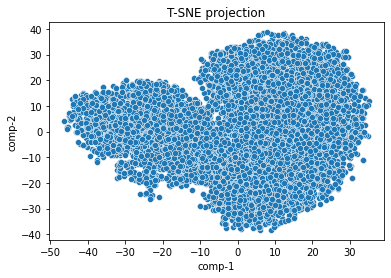

In [39]:
df = pd.DataFrame()
df["y"] = pred
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2",
                palette=sns.color_palette("hls", 3),
                data=df).set(title="T-SNE projection") 

In [40]:
import os
# Define the checkpoint directory to store the checkpoints
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [41]:
# Function for decaying the learning rate.
# You can define any decay function you need.
def decay(epoch):
    if epoch < 3:
        return 1e-1
    elif epoch >= 3 and epoch < 5:
        return 1e-2
    else:
        return 1e-5

In [42]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [43]:
X_train = tf.stack(X_train)
X_text_train = tf.stack(X_text_train)
y_train = tf.stack(y_train)

In [44]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics='accuracy')

history = model.fit(x = {"image_input": X_train, "text": X_text_train},
                    y = y_train,
                    batch_size=64,
                    epochs=15
                   )

Epoch 1/15
155/155 [==============================] - 85s 497ms/step - loss: 1.0039 - accuracy: 0.6904
Epoch 2/15
155/155 [==============================] - 78s 501ms/step - loss: 0.8964 - accuracy: 0.6930
Epoch 3/15
155/155 [==============================] - 80s 518ms/step - loss: 0.8143 - accuracy: 0.6930
Epoch 4/15
155/155 [==============================] - 81s 521ms/step - loss: 0.7503 - accuracy: 0.6930
Epoch 5/15
155/155 [==============================] - 81s 523ms/step - loss: 0.7003 - accuracy: 0.6930
Epoch 6/15
155/155 [==============================] - 81s 523ms/step - loss: 0.6611 - accuracy: 0.6930
Epoch 7/15
155/155 [==============================] - 82s 526ms/step - loss: 0.6299 - accuracy: 0.6930
Epoch 8/15
155/155 [==============================] - 81s 521ms/step - loss: 0.6050 - accuracy: 0.6930
Epoch 9/15
155/155 [==============================] - 83s 534ms/step - loss: 0.5847 - accuracy: 0.6930
Epoch 10/15
155/155 [==============================] - 82s 527ms/step - l

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


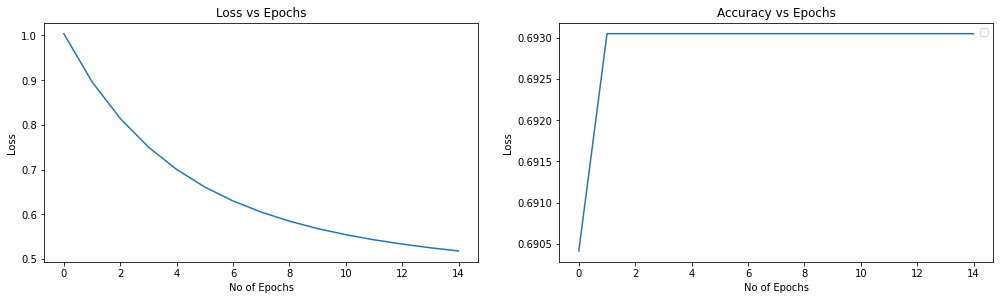

In [45]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
fig.tight_layout(pad=5.0)

axes[0].plot(pd.DataFrame(history.history).loss)
axes[0].set_xlabel('No of Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss vs Epochs')

axes[1].plot(pd.DataFrame(history.history).accuracy)
axes[1].set_xlabel('No of Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Accuracy vs Epochs')
axes[1].legend()
plt.show()

In [46]:
X_test = tf.stack(X_test)
X_text_test = tf.stack(X_text_test)
y_test = tf.stack(y_test)

In [47]:
eval_ = model.evaluate(x = {"image_input": X_test, "text": X_text_test},
                    y = y_test,
                    batch_size=32,
                    verbose=1
                   )

78/78 [==============================] - 8s 77ms/step - loss: 0.5147 - accuracy: 0.6931


In [48]:
np.array(X_test).shape, np.array(X_text_test).shape

((2467, 60, 60, 3), (2467,))

In [49]:
from sklearn.metrics import f1_score, classification_report
prediction = model.predict(x = {"image_input": X_test, "text": X_text_test})
prediction = np.array(prediction)
#prediction = np.squeeze(prediction)
#prediction = 1/(1+np.exp(-np.array(prediction)))
#prediction = np.where(prediction > 0.5, 1, 0)
y_true = y_test

micro_f1_score = f1_score(np.argmax(y_true,axis=1), np.argmax(prediction,axis=1), average='micro')
macro_f1_score = f1_score(np.argmax(y_true,axis=1), np.argmax(prediction,axis=1), average='macro')

print("Micro F1 score for Task A is ", micro_f1_score)
print("Macro F1 score for Task A is ", macro_f1_score)

78/78 [==============================] - 7s 69ms/step
Micro F1 score for Task A is  0.6931495743818403
Macro F1 score for Task A is  0.566335321404904


In [50]:
print(classification_report(np.argmax(y_true, axis = 1), np.argmax(prediction, axis = 1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       757
           1       0.54      1.00      0.70       879
           2       1.00      1.00      1.00       831

    accuracy                           0.69      2467
   macro avg       0.51      0.67      0.57      2467
weighted avg       0.53      0.69      0.59      2467



D:\Users\hp\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\hp\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\hp\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
